In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import cv2
import imutils
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from scipy.signal import convolve2d
import mahotas as mt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift
from sklearn.model_selection import GridSearchCV
import joblib


tqdm.pandas()

In [2]:
def sum_of_pixel(file_path):
    img = np.array(Image.open(file_path).convert('L'))
    return np.sum(img) / (img.shape[0] * img.shape[1])

In [3]:
def image_colorfulness(file_path):
    image = cv2.imread(file_path)
    image = imutils.resize(image, width=250)
    
    (B, G, R) = cv2.split(image.astype("float"))
    
    rg = np.absolute(R - G)
    
    yb = np.absolute(0.5 * (R + G) - B)
    
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    
    return stdRoot + (0.3 * meanRoot)

In [4]:
def ngldm_features(file_path, radius=1, levels=256):
    image = imread(file_path, as_gray=True)
    
    image_normalized = (image - image.min()) / (image.max() - image.min()) * 255

    image_uint8 = image_normalized.astype(np.uint8)

    glcm = graycomatrix(image_uint8, distances=[radius], angles=[0], levels=levels,
                        symmetric=True, normed=True)

    ngldm_matrix = np.zeros((levels, levels), dtype=np.float64)

    for i in range(levels):
        for j in range(levels):
            ngldm_matrix[i, j] = np.sum(glcm[(i, j)])

    ngldm_matrix /= np.sum(ngldm_matrix)

    regularity = np.sum(ngldm_matrix ** 2)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    roughness = 1.0 / (1.0 + contrast)

    return regularity, roughness

In [5]:
def csar_classification(file_path, window_size=3, num_iterations=10, epsilon=1e-6):

    image = imread(file_path, as_gray=True)

    image = image.astype(float)

    height, width = image.shape

    mask = np.zeros((window_size, window_size))
    center = window_size // 2
    for i in range(window_size):
        for j in range(window_size):
            if (i - center) ** 2 + (j - center) ** 2 <= center ** 2:
                mask[i, j] = 1

    mask /= np.sum(mask)

    csar = np.random.rand(height, width)

    csar /= np.sum(csar)

    for _ in range(num_iterations):
        estimated_luminance = convolve2d(csar, mask, mode='same', boundary='wrap')

        csar += epsilon * convolve2d(image - estimated_luminance, mask, mode='same', boundary='wrap')

        csar /= np.sum(csar)

    smooth_texture_index = convolve2d(csar, np.ones((window_size, window_size)), mode='same', boundary='wrap') / (window_size ** 2)

    smooth_texture_index_avg = np.mean(smooth_texture_index)

    return smooth_texture_index_avg

In [6]:
def extract_features(file_path):
    image = cv2.imread(file_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = mt.features.haralick(gray)

    ht_mean = textures.mean(axis=0)
    return list(ht_mean)

In [7]:
def calculate_noise_level(image_path):
    # Load the image
    img = cv2.imread(image_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate standard deviation of pixel intensities
    noise_level = np.std(gray)
    return noise_level

In [8]:
def cfa_artifacts(image_path,  patch_size=128, frequency_range=(0.1, 0.5)):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Crop the image to the nearest multiple of patch size
    h, w = gray_img.shape
    h = h - (h % patch_size)
    w = w - (w % patch_size)
    gray_img = gray_img[:h, :w]

    # Compute the 2D Fourier transform of the image
    f_transform = fftshift(fft2(gray_img))

    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(f_transform)

    # Compute the power spectrum
    power_spectrum = np.abs(f_transform)**2

    # Define the frequency range of interest
    freq_min, freq_max = frequency_range
    freq_min_idx = int(power_spectrum.shape[0] * freq_min)
    freq_max_idx = int(power_spectrum.shape[0] * freq_max)

    # Calculate the sum of power within the frequency range
    power_within_range = np.sum(power_spectrum[freq_min_idx:freq_max_idx, freq_min_idx:freq_max_idx])

    # Normalize the sum by the total power in the spectrum
    total_power = np.sum(power_spectrum)
    cfa_metric = power_within_range / total_power

    return cfa_metric

In [9]:
def detect_editing_artifacts(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Calculate different features related to editing artifacts
    features = {}

    # detecting resampling artifacts
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    features['edge_density'] = edge_density

    # detecting blur inconsistencies
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    laplacian_var = cv2.Laplacian(blurred, cv2.CV_64F).var()
    features['laplacian_var'] = laplacian_var

    # detecting copy-move regions
    template = image[100:200, 100:200]  # Example region to search for duplicates
    res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    features['max_template_matching_score'] = max_val

    # Combine features into a single metric
    editing_artifacts_score = np.mean(list(features.values()))

    return editing_artifacts_score

In [10]:
if os.path.exists("yanport_dataset/df.csv"):
    df = pd.read_csv("yanport_dataset/df.csv")
else:
    df = pd.DataFrame(columns=['image_path', 'path_ela', 'label'])
    
    folder_path = 'yanport_dataset/REAL'
    real_df = pd.DataFrame(columns=['image_path', 'path_ela', 'label'])
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            file_path = os.path.join(folder_path, filename)
            row = {'image_path': file_path, 'path_ela': 'yanport_dataset/ELA_REAL/' + filename, 'label': 0}
            real_df = pd.concat([real_df, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    fake_df = pd.DataFrame(columns=['image_path', 'path_ela', 'label'])
    folder_path = 'yanport_dataset/FAKE'
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            file_path = os.path.join(folder_path, filename)
            row = {'image_path': file_path, 'path_ela': 'yanport_dataset/ELA_FAKE/' + filename, 'label': 1}
            fake_df = pd.concat([fake_df, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    df = pd.concat([real_df, fake_df], ignore_index=True)
    df.to_csv('yanport_dataset/df.csv', index=False)

# Computation of all metrics

In [2]:
if os.path.exists("yanport_dataset/df_all_features.csv"):
    df = pd.read_csv("yanport_dataset/df_all_features.csv")
else:
    df['sum_of_pixel'] = df['path_ela'].progress_apply(sum_of_pixel)
    df['colorfulness'] = df['image_path'].progress_apply(image_colorfulness)
    df['regularity'], df['roughness'] = zip(*df['image_path'].progress_apply(ngldm_features))
    df['haralick_0'], df['haralick_1'], df['haralick_2'], df['haralick_3'], df['haralick_4'], df['haralick_5'], df['haralick_6'], df['haralick_7'], df['haralick_8'], df['haralick_9'], df['haralick_10'], df['haralick_11'], df['haralick_12'] = zip(*df['image_path'].progress_apply(extract_features))
    df['noise_level'] = df['image_path'].progress_apply(calculate_noise_level)
    df['cfa_metric'] = df['image_path'].progress_apply(cfa_artifacts)
    df['editing_artifacts'] = df['image_path'].progress_apply(detect_editing_artifacts)
    df.to_csv('yanport_dataset/df_all_features.csv', index=False)

In [20]:
df.head()

,image_path,path_ela,label,sum_of_pixel,colorfulness,regularity,roughness,haralick_0,haralick_1,haralick_2,...,haralick_6,haralick_7,haralick_8,haralick_9,haralick_10,haralick_11,haralick_12,noise_level,cfa_metric,editing_artifacts
0,yanport_dataset/REAL/image_150f8cfc30ac356d839...,yanport_dataset/ELA_REAL/image_150f8cfc30ac356...,0,0.038382,27.747679,0.001543,0.023837,0.001470,50.646534,0.984323,...,6411.227862,8.268086,10.830674,0.000810,3.019451,-0.515105,0.999683,40.209768,0.000035,6.461608
1,yanport_dataset/REAL/13e0be7cc873dbcabd48889f6...,yanport_dataset/ELA_REAL/13e0be7cc873dbcabd488...,0,0.249186,42.651433,0.004252,0.005997,0.004024,213.509855,0.960777,...,10673.564348,8.049823,10.972093,0.000750,3.536543,-0.467267,0.999283,52.170784,0.000293,18.255786
2,yanport_dataset/REAL/image_1ae1a970b60cf6314e1...,yanport_dataset/ELA_REAL/image_1ae1a970b60cf63...,0,0.128516,20.294512,0.002597,0.004394,0.002815,211.351093,0.973558,...,15775.356909,8.336436,11.325154,0.000645,3.563451,-0.464221,0.999346,63.227844,0.000876,21.035454
3,yanport_dataset/REAL/image_6a87d3444834bfd55c4...,yanport_dataset/ELA_REAL/image_6a87d3444834bfd...,0,0.015636,18.823962,0.004711,0.043048,0.004323,33.803489,0.983070,...,3959.126482,7.473464,9.330304,0.001149,2.331651,-0.565591,0.999642,31.580500,0.032818,3.695253
4,yanport_dataset/REAL/1n07ij5hnlrnb5obg56a4q3fi...,yanport_dataset/ELA_REAL/1n07ij5hnlrnb5obg56a4...,0,0.071333,32.577699,0.001170,0.008072,0.000980,167.125970,0.976555,...,14090.519800,8.745994,11.448325,0.000839,3.155693,-0.528781,0.999839,59.716585,0.000367,14.197203


# Correlation between features and label

In [25]:
df = pd.read_csv('yanport_dataset/df_all_features.csv')

In [3]:
df_to_train = df.drop(['image_path', 'path_ela'], axis=1)

In [4]:
correlation = df_to_train.corr()['label'].sort_values(ascending=False)
print(correlation)

label                1.000000
sum_of_pixel         0.659217
editing_artifacts    0.549564
haralick_10          0.536784
haralick_11          0.484849
haralick_8           0.472646
haralick_1           0.472363
haralick_5           0.293679
haralick_7           0.284247
noise_level          0.272968
colorfulness         0.267556
haralick_3           0.252604
haralick_6           0.233419
regularity          -0.027770
haralick_0          -0.032110
haralick_12         -0.174979
cfa_metric          -0.285378
roughness           -0.356631
haralick_4          -0.394136
haralick_9          -0.451475
haralick_2          -0.452434
Name: label, dtype: float64


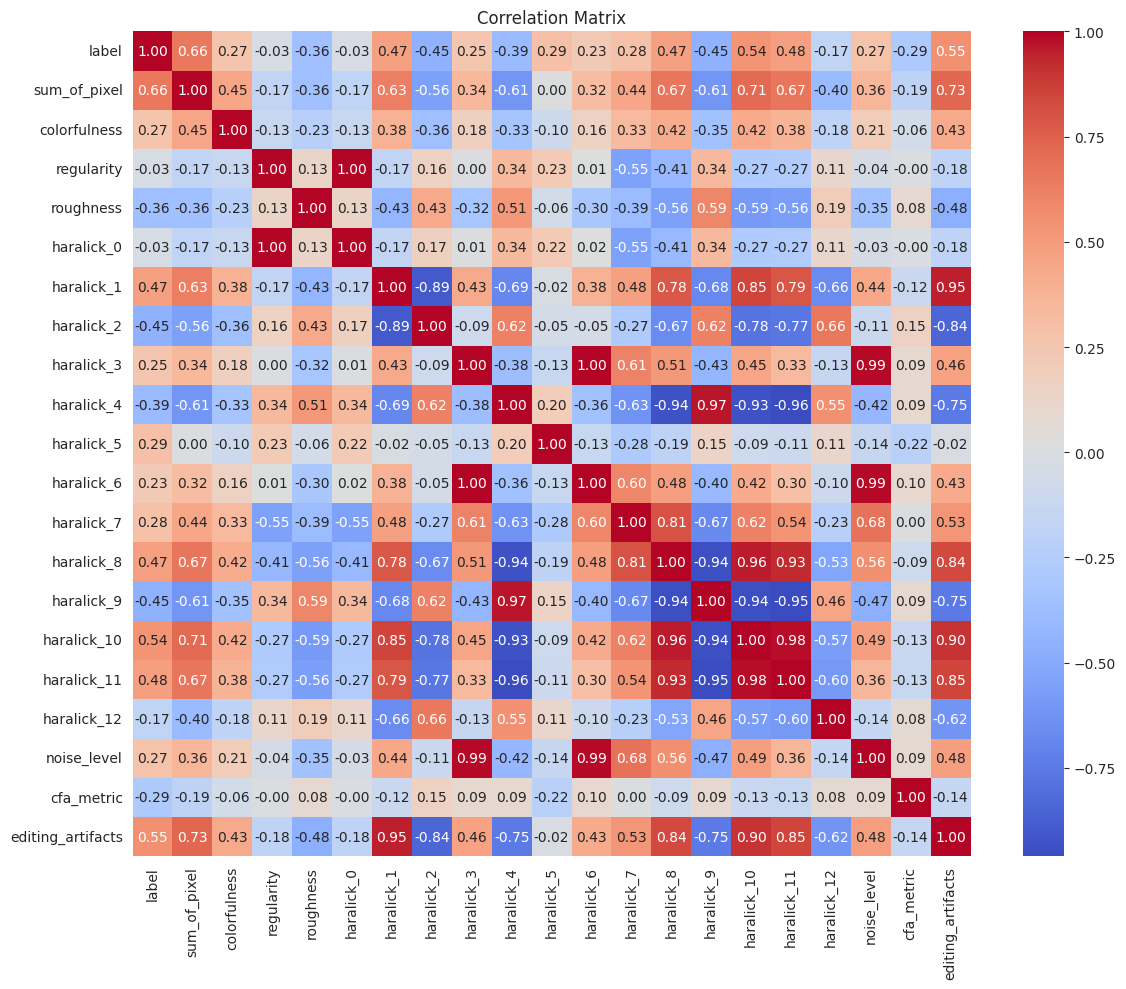

In [23]:
# plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df_to_train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

In [24]:
corr_matrix = df_to_train.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

tri_df = corr_matrix.mask(mask)

collinear_pairs = [(i,j) for i in tri_df.columns for j in tri_df.columns if abs(tri_df.loc[i,j]) > 0.95 and i!=j]

print('Collinear features :')
for pair in collinear_pairs:
    print(pair)

('haralick_0', 'regularity')
('haralick_6', 'haralick_3')
('haralick_9', 'haralick_4')
('haralick_10', 'haralick_8')
('haralick_11', 'haralick_4')
('haralick_11', 'haralick_9')
('haralick_11', 'haralick_10')
('noise_level', 'haralick_3')
('noise_level', 'haralick_6')
('editing_artifacts', 'haralick_1')


# Preprocessing of data

In [5]:
# features are selected based on correlation
features = list(correlation[abs(correlation) > 0.2].index)
features.remove('label')
features.remove('noise_level')
features.remove('editing_artifacts')
features.remove('haralick_6')
features.remove('haralick_9')
features.remove('haralick_10')
features.remove('haralick_4')
print(features)

['sum_of_pixel', 'haralick_11', 'haralick_8', 'haralick_1', 'haralick_5', 'haralick_7', 'colorfulness', 'haralick_3', 'cfa_metric', 'roughness', 'haralick_2']


In [6]:
df['label'] = df['label'].astype(int)

In [7]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [8]:
df[features].describe()

,sum_of_pixel,haralick_11,haralick_8,haralick_1,haralick_5,haralick_7,colorfulness,haralick_3,cfa_metric,roughness,haralick_2
count,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03,2.746000e+03
mean,-8.280178e-17,1.242027e-16,-9.108195e-16,-4.140089e-17,6.831146e-16,1.863040e-15,-2.070044e-16,8.280178e-17,2.070044e-17,2.070044e-17,-4.968107e-16
std,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00
min,-9.199688e-01,-3.075377e+00,-3.709667e+00,-1.064434e+00,-3.591036e+00,-6.074507e+00,-1.932523e+00,-2.345977e+00,-4.120390e-01,-5.951961e-01,-7.069739e+00
25%,-7.751013e-01,-7.507967e-01,-6.863410e-01,-7.357656e-01,-7.033446e-01,-4.341999e-01,-7.616622e-01,-7.140483e-01,-4.036556e-01,-4.612301e-01,-4.800986e-01
50%,-4.381182e-01,-5.721699e-03,3.571769e-02,-2.970870e-01,-2.665870e-02,2.559067e-01,-1.332789e-01,-3.409173e-02,-3.904278e-01,-3.072318e-01,2.427077e-01
75%,5.331606e-01,7.303276e-01,7.448869e-01,4.307846e-01,6.782927e-01,7.006804e-01,5.778741e-01,6.279096e-01,-3.459505e-01,6.662555e-02,7.439747e-01
max,4.959896e+00,3.119549e+00,2.761590e+00,6.586371e+00,3.083176e+00,1.515154e+00,5.012162e+00,4.380672e+00,7.294986e+00,1.505863e+01,1.243378e+00


# Classification

In [9]:
X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(best_params)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500; tot

In [10]:
best_params = {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Accuracy: 0.93
Recalls: 0.92
Precisions: 0.92
F1 Scores: 0.92


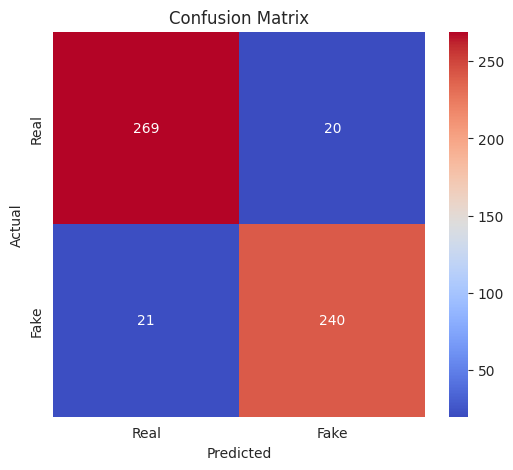

In [12]:
if os.path.exists('model_3.pkl'):
    rf_model = joblib.load('model_3.pkl')
else:
    rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], bootstrap=best_params['bootstrap'])
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, 'model_3.pkl')

rf_predictions = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_recalls = recall_score(y_test, rf_predictions)
rf_precisions = precision_score(y_test, rf_predictions)
rf_f1_scores = f1_score(y_test, rf_predictions)
print('Accuracy:', round(rf_accuracy, 2))
print('Recalls:', round(rf_recalls, 2))
print('Precisions:', round(rf_precisions, 2))
print('F1 Scores:', round(rf_f1_scores, 2))


cm = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Real', 'Fake'])
plt.yticks([0.5, 1.5], ['Real', 'Fake'])
plt.savefig('confusion_matrix.png')
plt.show()

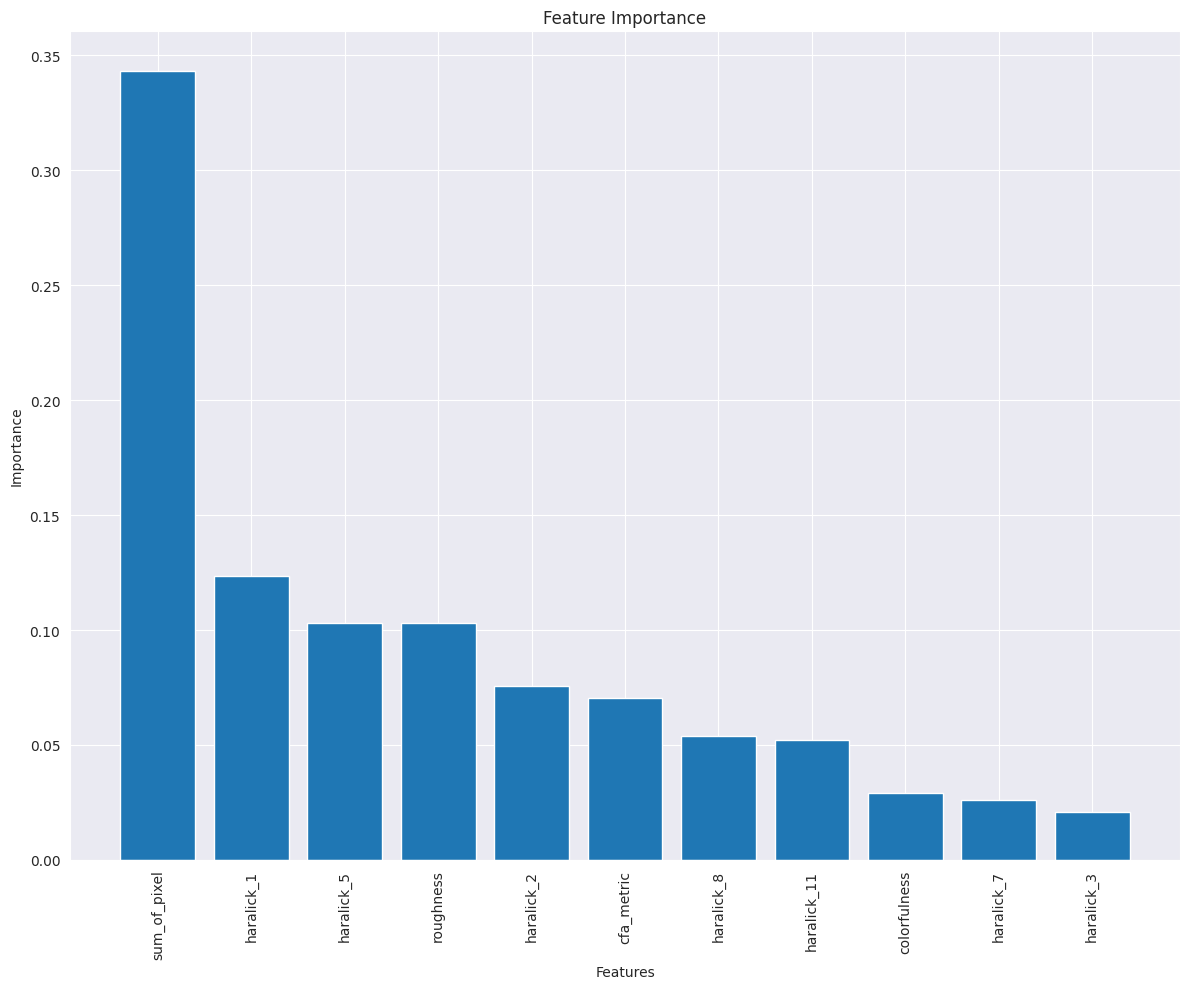

In [13]:
# plot feature importance and sort by importance
importance = rf_model.feature_importances_

features = np.array(features)
importance, features = zip(*sorted(zip(importance, features), reverse=True))

plt.figure(figsize=(12, 10))
plt.bar(features, importance)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [32]:
rf_predictions = rf_model.predict(X_test)
test_df = X_test.copy()
test_df['actual_label'] = y_test
test_df['predicted_label'] = rf_predictions
errors_df = test_df[test_df['actual_label'] != test_df['predicted_label']]
error_indices = errors_df.index
error_image_paths = df.loc[error_indices, 'image_path'].values
print(error_image_paths)

['yanport_dataset/FAKE/image_6682b6952e9bc698494ed185e4138572.jpeg'
 'yanport_dataset/FAKE/image_ac5828bde2545b96248b5540b19367e7.jpeg'
 'yanport_dataset/REAL/image_8140839472b34ade7e95b93c80b9b0a3.jpg'
 'yanport_dataset/FAKE/image_fd6b1f9af0d8c13922ae204f787676b8.jpg'
 'yanport_dataset/FAKE/image_c9c90752e90ba6a9f31c6bab06fca0ee.jpg'
 'yanport_dataset/REAL/1tcrc221vyx7uax9ykv5oxr5jk1n6puedn8ghgm8w.jpg'
 'yanport_dataset/FAKE/image_84ab97fe4f6126a468d8882c0e2e89f2.jpeg'
 'yanport_dataset/FAKE/image_bb9c82bb52ca438817fa9093363ca969.jpg'
 'yanport_dataset/FAKE/image_9a415f7a7680601c15bed598d84ccf75.jpg'
 'yanport_dataset/FAKE/image_de60e3da811e6eccc3ccb26280e4240c.jpeg'
 'yanport_dataset/FAKE/image_7fa6b6ae6e6d6fa626d53d567c80f3c0.jpeg'
 'yanport_dataset/REAL/image_e762c2dd612788993d7f781dcdde891c.jpg'
 'yanport_dataset/REAL/image_253fb2be36f84db206e645631b0d4eea.jpg'
 'yanport_dataset/FAKE/image_ccf9530af47d8a737da076908437889b.jpg'
 'yanport_dataset/REAL/image_78726d111d9720317aab63da9

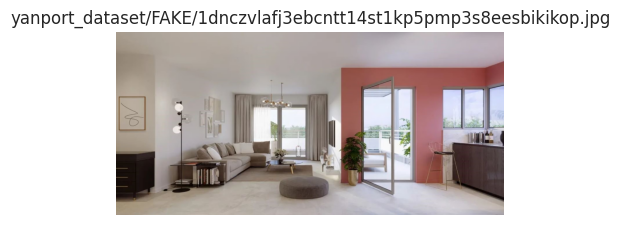

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_image_path = random.choice(error_image_paths)
img = mpimg.imread(random_image_path)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(random_image_path)
plt.axis('off')
plt.show()